<a href="https://colab.research.google.com/github/jettecampbell/data-science/blob/main/JettCampU8Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Project: Predicting World Happiness with BART

For this project, I chose a dataset that contained World Happiness Index (WHI)values (scored 0-10) for every country at varying years. In addition to index scores, the dataset also contained other intresting statistics such as product inflation rates and perceptions of corruption which I thought would be very interesting to use in order to determine WHI scores. Through a created BART model, I could predict which predictor best correlates with happiness and which ones could be ignored.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree
!pip install pymc-bart
!pip install preliz
import pymc_bart as pmb
import preliz as pz
url="https://raw.githubusercontent.com/jettecampbell/data-science/refs/heads/main/WHI_Inflation.csv"
WHI = pd.read_csv(url).dropna()

The dataset included region for each country, so I converted each region from a categorical value to an integer so it could be used as a postierior predictor.

In [2]:
WHindex = pd.DataFrame(columns = ['', ' '])

#turns the region column into a categorical variable
WHindex['Continent/Region'] = pd.Categorical(WHI['Continent/Region'])

#this is an array of the world regions
region_idx = WHindex['Continent/Region'].cat.codes.values

#an array of the strings that represent region
region_codes = WHindex['Continent/Region'].cat.categories

#puts coords in a dict, so pymc can read them
region_coords = {"Continent/Region": region_codes}

WHI['Region'] = region_idx


In [3]:
region_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5,
       5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9,
       9, 9, 6, 6, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In addition to Region, the predictors I chose for determing WHI Score were Energy Price Inflation, Food Price Inflation, GDP per Capita, and Perceptions of corruption. I chose each of these because they were very different metrics from one another. Both inflation statistics correlate with macroeconomic trends, while GDP per capita focuses more on the individual. On the other hand, perceptions of corruption is not directly associated with economy at all and correlates more with the social and politcal climate of each country.

In [4]:
values = ["Region","Energy Consumer Price Inflation", "Food Consumer Price Inflation","GDP per Capita","Perceptions of corruption"]

X = WHI[values]
Y = WHI["Score"].to_numpy()

I decided a normal model would work best for WHI score due to the dataset values likely being relativly normally distrubuted around its mean.

In [5]:
with pm.Model() as model_octps:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_octps = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

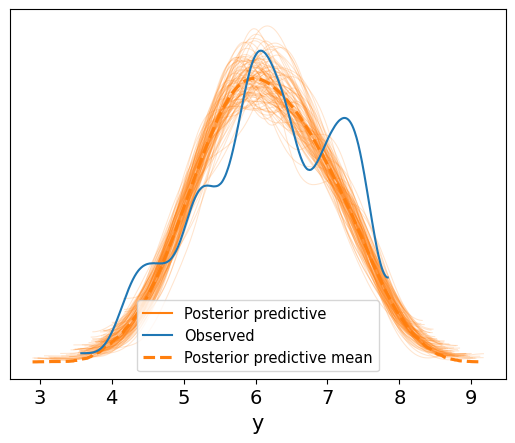

In [6]:
pm.sample_posterior_predictive(idata_octps,model_octps, extend_inferencedata=True)
az.plot_ppc(idata_octps, num_pp_samples=100, colors=["C1", "C0", "C1"])

The posterior predictive plot fit the data pretty well, especially at the tails. The observed data's extra curves did go a bit out of the predictive range, but they weren't big enough to effect the predictive curve so this is about the best it will get.

In [7]:
posterior_mean = idata_octps.posterior["μ"]

μ_hdi = az.hdi(ary=idata_octps, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_octps, group="posterior_predictive", var_names=["y"]
).T

In [8]:
Xn = X.to_numpy()

Next, I decided to create a HDI predictive plot that used just one predictor. My guess was the GDP per capita would be the best solo-predictor because more money per person = more happiness.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


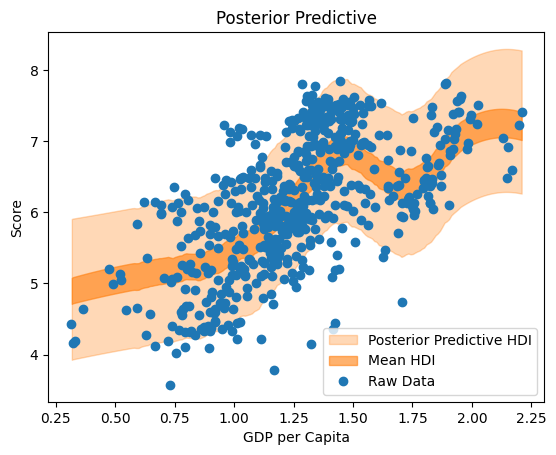

In [9]:
idx = np.argsort(Xn[:, 3])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 3],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=Xn[:, 3],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(WHI["GDP per Capita"], WHI["Score"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="GDP per Capita",
    ylabel="Score",
);

The plot resulted with a predictive HDI that very closely matched the actual data, and there is an obvious correlation between GDP per Capita and HDI score. To check the individual relationships between each of the predictors and HDI score, I also created pdp and ice plots.

array([<Axes: xlabel='Region'>,
       <Axes: xlabel='Energy Consumer Price Inflation'>,
       <Axes: xlabel='Food Consumer Price Inflation'>,
       <Axes: xlabel='GDP per Capita'>,
       <Axes: xlabel='Perceptions of corruption'>], dtype=object)

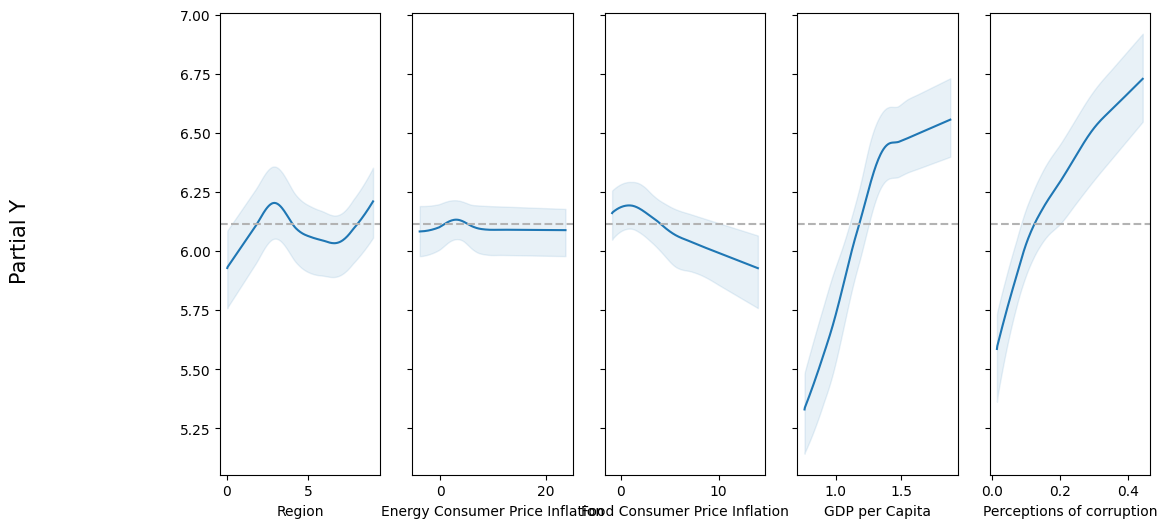

In [10]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='Region'>,
       <Axes: xlabel='Energy Consumer Price Inflation'>,
       <Axes: xlabel='Food Consumer Price Inflation'>,
       <Axes: xlabel='GDP per Capita'>,
       <Axes: xlabel='Perceptions of corruption'>], dtype=object)

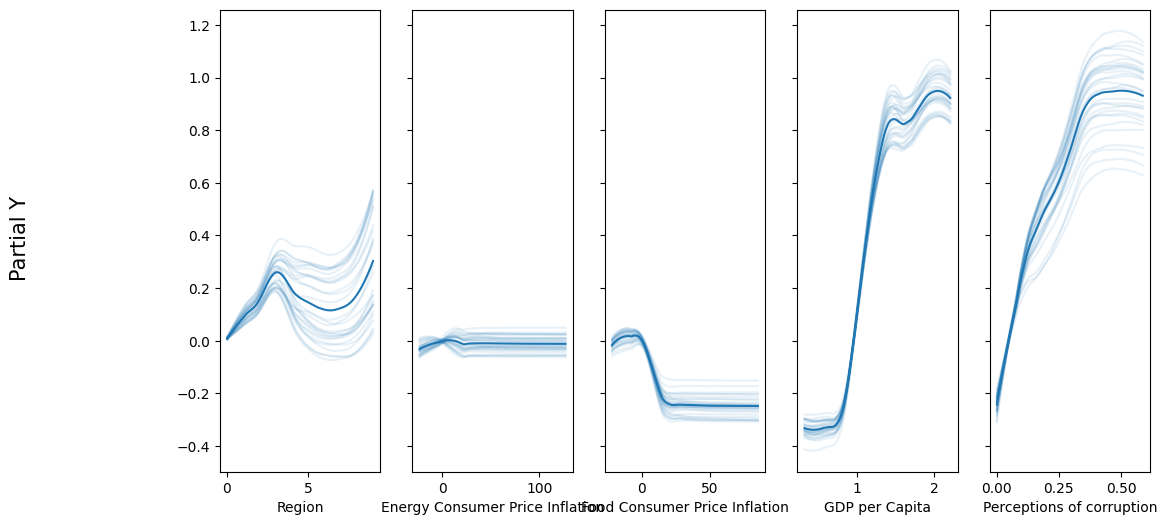

In [11]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

As I originally assumed, GDP per Capita showed a very direct correlation with WHI score. Addititionally however, perceptions of corruption was maybe even more correlated than GDP with WHI score which suprised me, especially with it being a positive correlation. Seeing this, I did more research into the corruption index used in the dataset and found out that a higher value actually means less corruption, so this relation made more sense. Region showed to have some influence, while Food Price inflation had a negative correlation which made sense. Energy inflation on the other hand had little to no correlation
which was a bit unexpected.

Next I created a pmb plot to determine each predictors influence on the BART model.

In [12]:
vi_WHI = pmb.compute_variable_importance(idata_octps, μ_, X)

<Axes: ylabel='R²'>

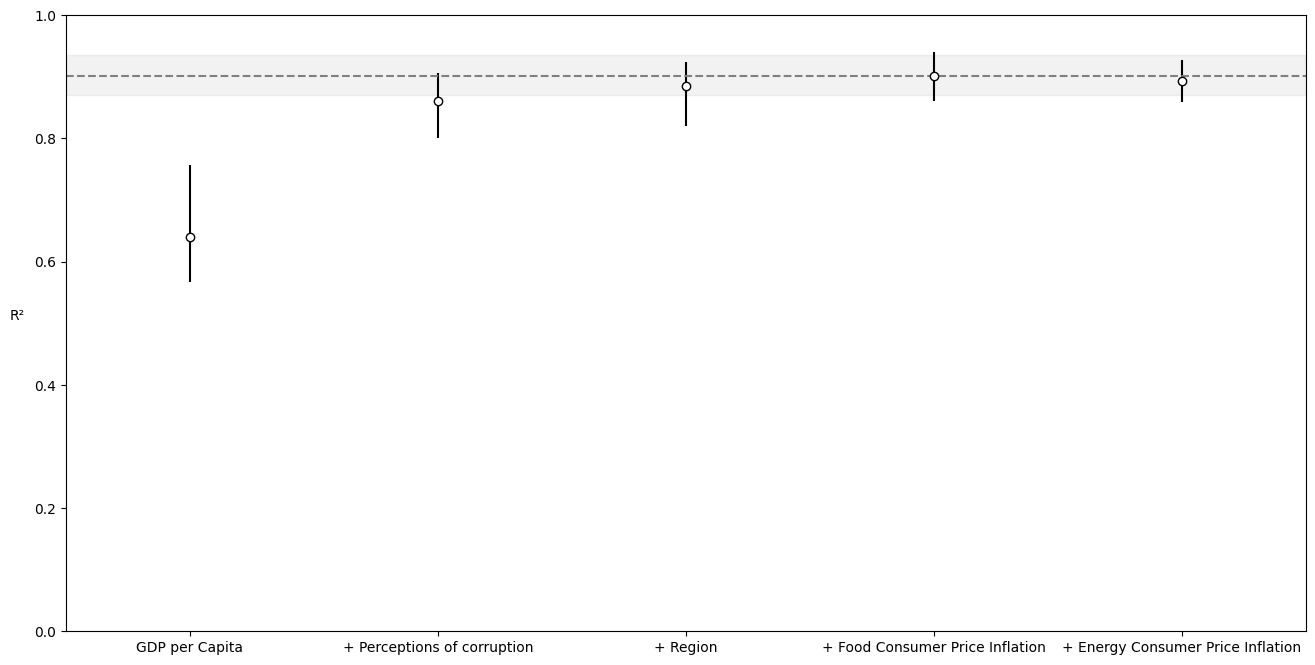

In [13]:
pmb.plot_variable_importance(vi_WHI, figsize = (16,8))

I drew a similar conclusion from the pmb and previous ice plots, showing GDP per capita and corruption to be the main factors in predicting this model. Region showed some influence and both price inflation stats showed very little influence.

Since perceptions of corruption showed to be a significant influence, I decided to create its own HDI plot.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


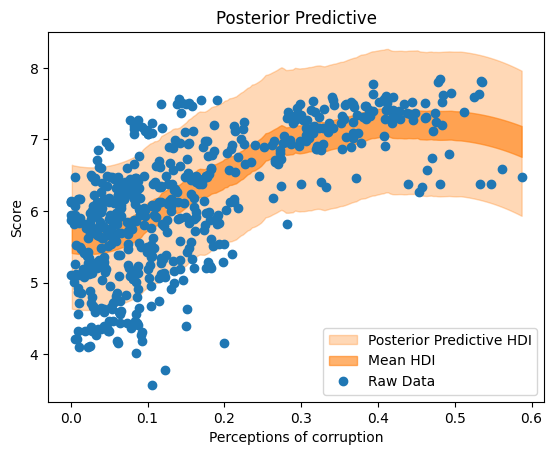

In [14]:
idx = np.argsort(Xn[:, 4])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 4],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=Xn[:, 4],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(WHI["Perceptions of corruption"], WHI["Score"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Perceptions of corruption",
    ylabel="Score",
);

This HDI predictive model also displayed a very obvious positive correlation between perceptions of corruption and HDI score, matching the raw data super closely.

Next, I removed both price inflation predictors to see if the rest could create a similar output and that there were no underlying interactions.

In [15]:
values2 = ["Region","GDP per Capita","Perceptions of corruption"]

X2 = WHI[values2]
Y2 = WHI["Score"].to_numpy()

In [16]:
with pm.Model() as model_octps2:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X2, np.log(Y2), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y2)
    idata_octps2 = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

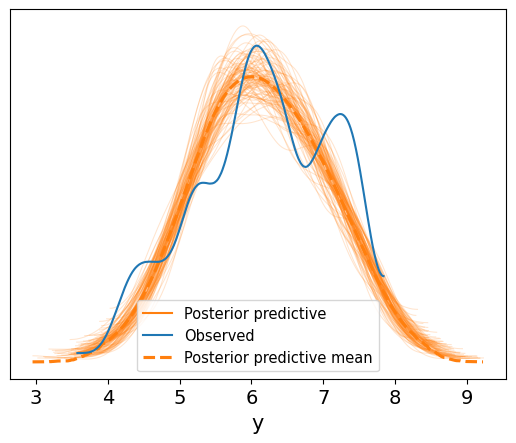

In [17]:
pm.sample_posterior_predictive(idata_octps2,model_octps2, extend_inferencedata=True)
az.plot_ppc(idata_octps2, num_pp_samples=100, colors=["C1", "C0", "C1"])

In [18]:
vi_WHI2 = pmb.compute_variable_importance(idata_octps2, μ_, X2)

<Axes: ylabel='R²'>

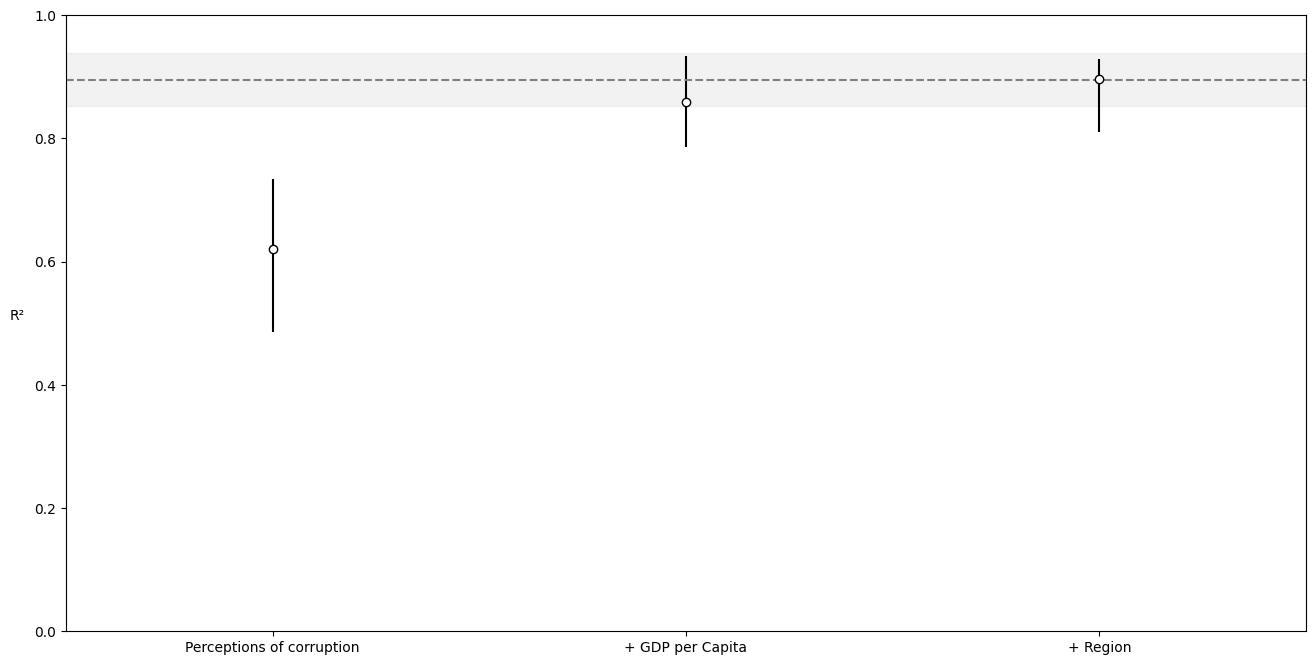

In [19]:
pmb.plot_variable_importance(vi_WHI2, figsize = (16,8))

Without Energy and Food consumer inflation rates, almost identical results are shown for the posterior predictive and R^2 value. This shows that there is not any significant interactions between the remaining predictors and the removed predictors which allows a similar result to be created easier. One difference I did notice was that perceptions of corruption without the other predictors shows more variable importance than it did with the inflation statistics while the opposite can be said for GDP per Capita. My best guess is that there were some interactions that were removed in the second model, however in the end it creates almost the same output.

Overall, GDP per Capita and Perceptions of corruption were the most significant predictors for estimating World Happiness Index score, both with positive correlations. This conclusion is mostly what I expected due to both statistics playing big roles in everday life. With the removal of inflation predictors, it seems that consumer prices don't have much affect on WHI score, but overall wealth and government climate do.